Tests for reproducibility of results from a stochastic Boolean network model as a function of sample size.

In [1]:
import ipywidgets as ipw
from IPython.display import display
import json
from matplotlib import pyplot as plt
import numpy as np
import os
from typing import Dict, List

try:
    from . import sim_lib
except ImportError:
    import sim_lib


# Assume location of previously generated results.
res_dir = os.path.join(os.getcwd(), 'results', 'boolean')

In [2]:
def get_data(fp: str):
    with open(fp, 'r') as f:
        data = json.load(f)

    cell_ids: List[int] = data['cell_ids']
    steps: List[int] = data['steps']
    cell_data: List[Dict[int, Dict[str, float]]] = [{int(k): v for k, v in e.items()} for e in data['cell_data']]
    var_names = list(cell_data[0][cell_ids[0]].keys())

    output = {n: np.ndarray((len(cell_ids), len(steps)), dtype=float) for n in var_names}
    for j, step_data in enumerate(cell_data):
        for i, cd in step_data.items():
            for n in var_names:
                output[n][i, j] = cd[n]
    return var_names, steps, output


var_names = None
steps = None
data_sizes = {}
for file_name in [f for f in os.listdir(res_dir) if f.startswith('output_') and f.endswith('.json') and f != 'output_summary.json']:
    var_names, steps, op = get_data(os.path.join(res_dir, file_name))
    data_sizes[op[var_names[0]].shape[0]] = op
sizes_sorted = list(data_sizes.keys())
sizes_sorted.sort()

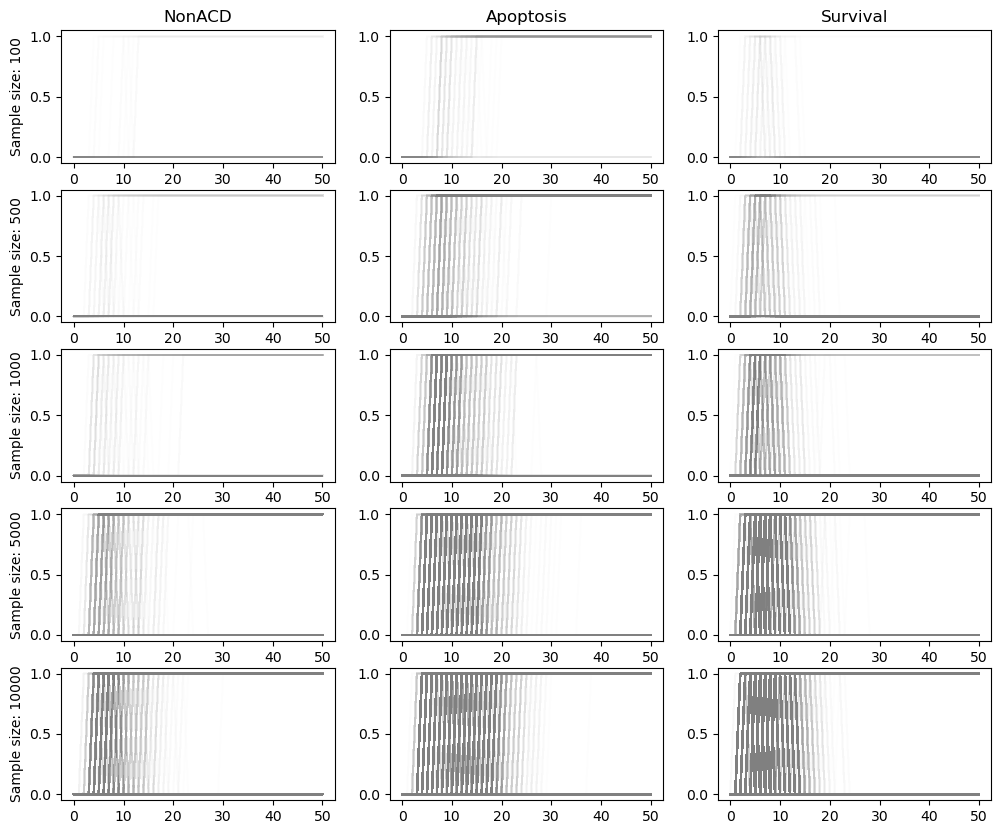

In [3]:
fig, axs = plt.subplots(len(data_sizes.keys()), len(var_names), figsize=(12.0, 2.0 * len(data_sizes.keys())))

for i, sz in enumerate(sizes_sorted):
    for j, name in enumerate(var_names):
        data_name = data_sizes[sz][name]
        for k in range(sz):
            axs[i][j].plot(steps, data_name[k, :], alpha=0.01, color='gray')
    axs[i][0].set_ylabel(f'Sample size: {sz}')
for i, name in enumerate(var_names):
    axs[0][i].set_title(name)

In [4]:
out = ipw.Output()
display(out)

ks_stats_sampling_sz = {}
for sz, data_sz in data_sizes.items():
    ks_stats_sampling_sz[sz] = sim_lib.test_sampling(data_sz, err_thresh=1E-3, out=out)[0]

Output()

In [5]:
with open(os.path.join(res_dir, 'output_summary.json'), 'w') as f:
    json.dump(dict(error=ks_stats_sampling_sz), f, indent=4)

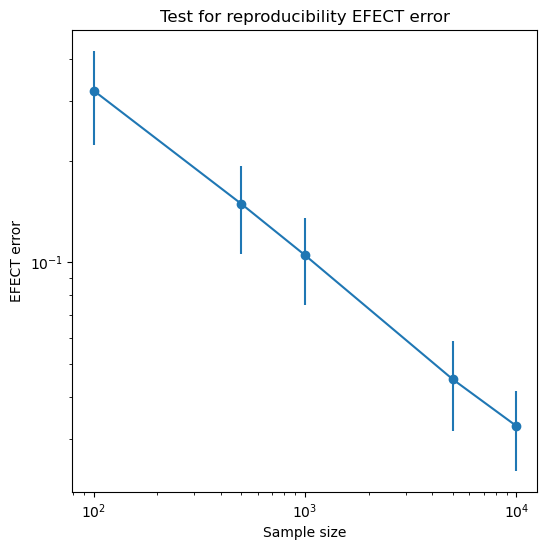

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6.0, 6.0))
error_avg = [np.average(ks_stats_sampling_sz[sz]) for sz in sizes_sorted]
error_std = [np.std(ks_stats_sampling_sz[sz]) for sz in sizes_sorted]
ax.errorbar(sizes_sorted, error_avg, yerr=error_std, marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Sample size')
ax.set_ylabel('EFECT error')
_ = ax.set_title('Test for reproducibility EFECT error')